# Прогноз солнечной радиации

# <a name="0.0"></a>Содержание:
* [Описание признаков](#1.)
* [Подготовка датасета](#2.)
* [Общая информация](#3.)
* [Подготовка данных](#4.)
* [Модели](#5.)
    - [Linear Regression](#5.1.)
    - [Random Forest](#5.2.)
    - [LightGBM](#5.3.)
    - [CatBoost](#5.4.)
    - [Сравнение результатов](#5.5.)
    - [Проверка на тестовых данных](#5.5.)
* [Вывод](#6.)

<a name="1."></a>
## Описание признаков
<font size="2">([к содержанию](#0.0))</font>

- **UNIXTime:** Время в формате UNIX;
- **Data:** Дата, включающая информацию о годе, месяце и дне проведения измерения солнечной радиации;
- **Time:** Время измерения солнечной радиации в формате час:минуты:секунды;
- **Radiation:** Значение солнечной радиации, Ватт на метр квадратный;
- **Temperature:** Температура воздуха в градусах Фаренгейта;
- **Pressure:** Атмосферное давление в дюймах, Hg;
- **Humidity:** Влажность воздуха в процентах;
- **WindDirection(Degrees):** Направление ветра в градусах;
- **Speed:** Скорость ветра в милях в час;
- **TimeSunRise:** Время восхода солнца;
- **TimeSunSet:** Время заката солнца.

<a name="2."></a>
## Подготовка датасета
<font size="2">([к содержанию](#0.0))</font>

### Импорт библиотек

In [1]:
# основные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# подготовка данных
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# модели
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

# метрика
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

### Загрузка данных

In [2]:
try:
    data = pd.read_csv('/Users/pavelspirin/ODS/Pet_projects/Solar_Radiation/SolarPrediction.csv')
    print('File load: Success through desktop computer')
except:
    print('File load: Failed')

File load: Success through desktop computer


<a name="3."></a>
## Общая информация
<font size="2">([к содержанию](#0.0))</font>

In [3]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [5]:
# Переименуем признаки
data.columns = ['UNIXTime', 'data', 'time', 'radiation', 'temperature', 'pressure', 'humidity', 'wind_direction', 'speed', 'time_sun_rise', 'time_sun_set']

In [6]:
# Выделим из признаков `data` и `time` отдельные признаки, такие как `month`, `day`, `hour`, `minute`, `second`
data['month'] = pd.to_datetime(data['data']).dt.month
data['day'] = pd.to_datetime(data['data']).dt.day

data['hour'] = pd.to_datetime(data['time']).dt.hour
data['minute'] = pd.to_datetime(data['time']).dt.minute
data['second'] = pd.to_datetime(data['time']).dt.second

# А так же разобъём `time_sun_rise` и `time_sun_rise` на часы и минуты
data['rise_hour'] = pd.to_datetime(data['time_sun_rise']).dt.hour
data['rise_minute'] = pd.to_datetime(data['time_sun_rise']).dt.minute

data['set_hour'] = pd.to_datetime(data['time_sun_set']).dt.hour
data['set_minute'] = pd.to_datetime(data['time_sun_set']).dt.minute

# И сразу удалим не нужные признаки `UNIXTime`, `data`, `time`, `time_sun_rise` и `time_sun_set`
data.drop(['UNIXTime', 'data', 'time', 'time_sun_rise', 'time_sun_set'], axis = 1, inplace = True)

In [7]:
data.head()

,radiation,temperature,pressure,humidity,wind_direction,speed,month,day,hour,minute,second,rise_hour,rise_minute,set_hour,set_minute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


Построим тепловую карту корреляционной матрицы

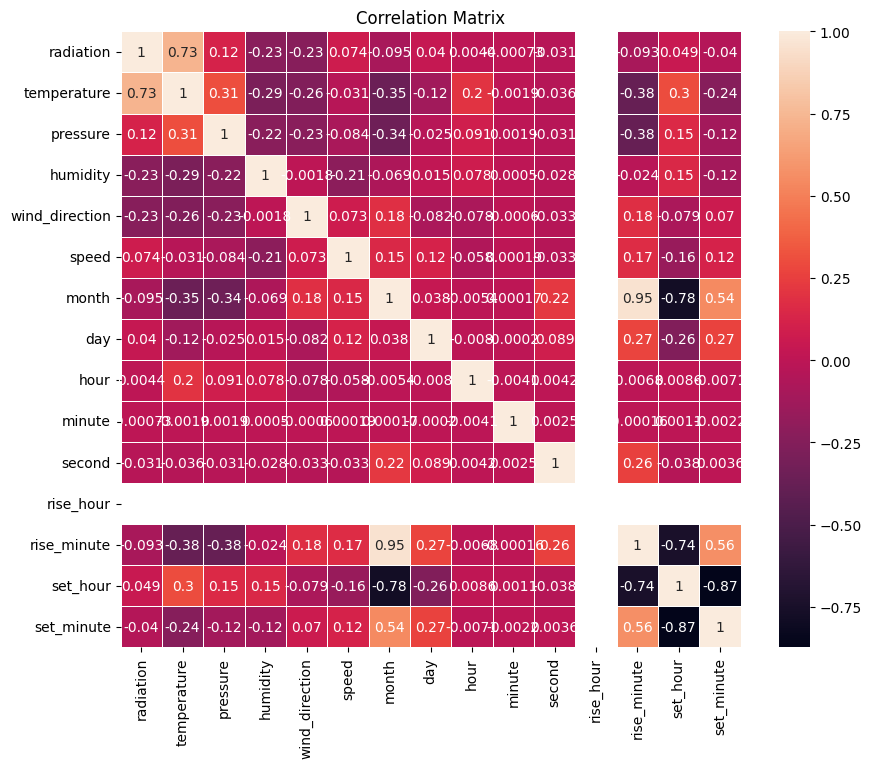

In [8]:
# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

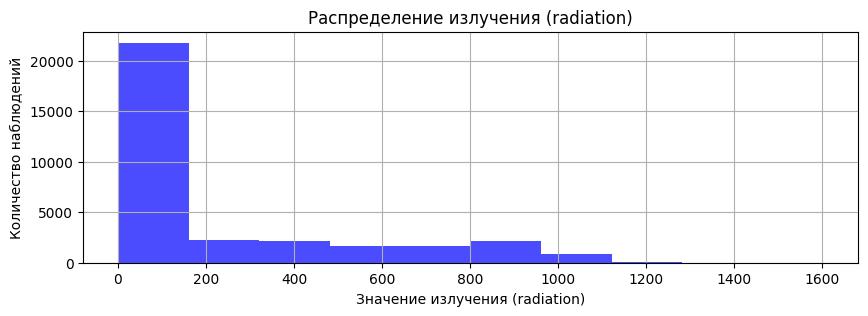

In [9]:
plt.figure(figsize=(10, 3))
plt.hist(data.radiation, bins=10, color='blue', alpha=0.7)
plt.xlabel('Значение излучения (radiation)')
plt.ylabel('Количество наблюдений')
plt.title('Распределение излучения (radiation)')
plt.grid(True)
plt.show()

#### Промежуточный вывод:

1. Radiation и Temperature имеют высокую положительную корреляцию (приближенную к 0.735), что означает, что при увеличении температуры увеличивается солнечная радиация;
2. Radiation и Humidity имеют отрицательную корреляцию (приближенную к -0.226), что означает, что солнечная радиация уменьшается при увеличении влажности.
Radiation и WindDirection(Degrees) также имеют слабую отрицательную корреляцию (приближенную к -0.230), что может указывать на некоторую связь между направлением ветра и солнечной радиацией;
3. Существует высокая корреляция между месяцем и временем восхода и заката солнца;
4. Значение rise_hour не меняются в течение всего промежутка измерения;
5. Многие из столбцов с временем (hour, minute, second, rise_hour, rise_minute, set_hour, set_minute) имеют очень слабую корреляцию с другими признаками, что ожидаемо, так как это временные параметры.

<a name="4."></a>
## Подготовка данных
<font size="2">([к содержанию](#0.0))</font>

В качестве подготовки данных для применения моделей применим разделение данных на выборки (трейн, валид, тест)

In [10]:
# Разбиваем данные на трейн и тест
X, y = data.drop('radiation', axis=1), data['radiation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(26148, 14)
(26148,)
(6538, 14)
(6538,)


(None, None)

Проведем сдандартизацию данных с помощью метода StandardScaler. Данный метод выравнит веса признаков путем преобразования их распределения так, чтобы они имели среднее значение (математическое ожидание) равное нулю и стандартное отклонение равное единице. Такое преобразование положительно влияет на линейные и деревянные модели МО. Для бустингов будем применять нестандартизированные выборки, так как они это делают "под копотом".

In [11]:
# Создадим объект стандартизации данных для линейной модели и случайного леса
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

<a name="5."></a>
## Модели
<font size="2">([к содержанию](#0.0))</font>

Обучим четыре модели, чтобы определить с какой дальше работать. Для этого возьмем линейную регрессию, случайный лес и два градиентных бустинга.

Смотреть результат будем по метрике RMSE  
Метрика RMSE (среднеквадратичная ошибка корня, англ. Root Mean Square Error) - это метрика оценки точности модели. RMSE измеряет среднеквадратичное отклонение прогнозных значений модели от фактических значений в наборе данных.  
Основная идея RMSE заключается в том, чтобы измерить среднее квадратичное отклонение между прогнозами модели и реальными данными. Большие значения RMSE указывают на то, что модель имеет высокую среднюю ошибку прогнозирования, тогда как меньшие значения RMSE указывают на более точные прогнозы.

<a name="5.1"></a>
### Linear Regression
<font size="2">([к содержанию](#0.0))</font>

In [12]:
# Создаем функцию для вычисления RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Создаем scorer для RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Создаем объект Ridge регрессии с выбранным параметром alpha (силы регуляризации)
ridge = Ridge(alpha=1.0)

scores = cross_val_score(ridge, X_train_ss, y_train, cv=5, scoring=rmse_scorer)

rmse_scores = -scores

print(f'Среднее RMSE Linear Regression с L2-регуляризацией: {np.mean(rmse_scores)}')

Среднее RMSE Linear Regression с L2-регуляризацией: 192.88925049026597


<a name="5.2"></a>
### Random Forest
<font size="2">([к содержанию](#0.0))</font>

Мы можем оптимизировать гиперпараметры RF-модели с использованием RandomizedSearchCV (более беглый подбор гиперпараметров, чем GridSearchCV). Гиперпараметры, которые мы будем настраивать:

- **n_estimators:** число деревьев в лесу.
- **max_features:** количество признаков для выбора при разделении узла.
- **max_depth:** максимальная глубина деревьев.
- **min_samples_split:** минимальное число объектов для разделения узла.
- **min_samples_leaf:** минимальное число объектов в листьях.

Здесь можно найти все о гиперпараметрах RF-модели: [Гиперпараметры](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [13]:
# Определим сетку гиперпараметров для перебора
n_estimators = range(10, 1000, 50)
max_features = ['log2', 'sqrt']
max_depth = [None] + list(range(2, 7))
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

param_grid = {'n_estimators': n_estimators, 
                 'max_features': max_features, 
                 'max_depth': max_depth, 
                 'min_samples_split': min_samples_split, 
                 'min_samples_leaf': min_samples_leaf}

rfr = RandomForestRegressor(random_state=13)

grid_search = RandomizedSearchCV(rfr, param_grid, 
                                 n_iter = 100, cv=5, 
                                 n_jobs=-1, verbose = 1, 
                                 scoring='neg_root_mean_squared_error', 
                                 random_state=13)

grid_search.fit(X_train_ss, y_train)

print(f'Лучшие гиперпараметры: {grid_search.best_params_}')
print(f'Лучшая оценка качества: {grid_search.best_score_ * -1}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие гиперпараметры: {'n_estimators': 710, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Лучшая оценка качества: 91.25250016372549


<a name="5.3"></a>
### LightGBM
<font size="2">([к содержанию](#0.0))</font>

- **n_estimators:** определяет количество деревьев (или итераций), которые будут использоваться в ансамбле. Большее количество деревьев может улучшить точность модели, но может также привести к переобучению;
- **num_leaves:** определяет количество листьев в каждом дереве. Большее число листьев может увеличить сложность модели, но также может увеличить риск переобучения;
- **learning_rate:** определяет величину, на которую каждое дерево вносит вклад в итоговый результат. Больший learning rate может ускорить обучение, но может также привести к менее стабильным результатам;
- **max_depth:** определяет максимальную глубину каждого дерева в ансамбле. Большая глубина позволяет модели лучше адаптироваться к данным, но также может способствовать переобучению.

In [14]:
param_grid = {
    'n_estimators':  range(10, 100, 5),
    'num_leaves': range(2, 30, 2),
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'max_depth': [None] + list(range(2, 7))
}

lgbm = lgb.LGBMRegressor(random_state=13)

grid_search_lgbm = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')

grid_search_lgbm.fit(X_train, y_train)

print(f'Лучшие гиперпараметры для LightGBM: {grid_search_lgbm.best_params_}')
print(f'Лучшая оценка качества для LightGBM: {grid_search_lgbm.best_score_ * -1}')

Fitting 5 folds for each of 6048 candidates, totalling 30240 fits
Лучшие гиперпараметры для LightGBM: {'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 95, 'num_leaves': 28}
Лучшая оценка качества для LightGBM: 83.37322428346337


<a name="5.4"></a>
### CatBoost
<font size="2">([к содержанию](#0.0))</font>

- **iterations:** определяет количество итераций (деревьев), которые будут использоваться в ансамбле. Большее количество итераций может увеличить точность модели, но также может увеличить время обучения;
- **learning_rate:** определяет величину, на которую каждое дерево вносит вклад в итоговый результат. Больший learning rate может ускорить обучение, но может также привести к менее стабильным результатам;
- **depth:** определяет максимальную глубину каждого дерева в ансамбле. Большая глубина позволяет модели лучше адаптироваться к данным, но также может способствовать переобучению.

In [15]:
param_grid = {
    'iterations': range(100, 1000, 100),
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'depth': range(2, 7)
}


catboost = CatBoostRegressor(random_state=13, verbose=0)

grid_search_catboost = GridSearchCV(catboost, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')

grid_search_catboost.fit(X_train, y_train)

print(f'Лучшие гиперпараметры для CatBoost: {grid_search_catboost.best_params_}')
print(f'Лучшая оценка качества для CatBoost: {grid_search_catboost.best_score_ * -1}')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Лучшие гиперпараметры для CatBoost: {'depth': 6, 'iterations': 900, 'learning_rate': 0.1}
Лучшая оценка качества для CatBoost: 82.6034367682183


<a name="5.5"></a>
### Сравнение результатов
<font size="2">([к содержанию](#0.0))</font>

In [16]:
# Создаем словарь с результатами
results = {
    'Модель': ['Linear Regression', 'Random Forest', 'LightGBM', 'CatBoost'],
    'Best RMSE': [
        np.mean(rmse_scores), 
        grid_search.best_score_ * -1,
        grid_search_lgbm.best_score_ * -1, 
        grid_search_catboost.best_score_ * -1
    ]
}

pd.DataFrame(results).sort_values(by='Best RMSE')

,Модель,Best RMSE
3,CatBoost,82.603437
2,LightGBM,83.373224
1,Random Forest,91.252500
0,Linear Regression,192.889250


**Промежуточный вывод:** На основании результатов оценки производительности различных моделей машинного обучения, можно сделать вывод, что как CatBoost, так и LightGBM и Random Forest превосходят линейную регрессию с L2-регуляризацией в задаче регрессии. Самым точным в прогнозировании оказался CatBoost с RMSE в размере 82.60, что указывает на его способность предсказывать целевую переменную с наименьшей средней квадратичной ошибкой. Проверим ее на тестовых данных

<a name="5.6"></a>
### Проверка на тестовых данных
<font size="2">([к содержанию](#0.0))</font>

In [17]:
best_params = grid_search_catboost.best_params_
best_catboost = CatBoostRegressor(**best_params, random_state=13, verbose=0)
best_catboost.fit(X_train, y_train)
y_pred_test = best_catboost.predict(X_test)
print(f'RMSE на тестовых данных: {mean_squared_error(y_test, y_pred_test, squared=False)}')

RMSE на тестовых данных: 81.11084118689509


Так же сравним нашу модель с константной моделью

In [18]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)
print(f'RMSE константной модели (предсказание среднего значения): {mean_squared_error(y_test, dummy_predictions, squared=False)}')

RMSE константной модели (предсказание среднего значения): 315.04286234446187


**Промежуточный вывод:** из анализа видно, что модель CatBoost показывает еще более лучший результат чем на тренировочных данных. Так же модель работают явно лучше, чем константная модель Dummy, которая предсказывает случайное число.

<a name="6."></a>
## Вывод
<font size="2">([к содержанию](#0.0))</font>

В ходе исследования данных и построения моделей для прогнозирования солнечной радиации были выявлены следующие ключевые моменты:

1. **Корреляционный анализ:** Исследование корреляций между признаками позволило выявить сильную положительную корреляцию между солнечной радиацией (Radiation) и температурой (Temperature). Также были обнаружены отрицательные корреляции с влажностью (Humidity) и направлением ветра (WindDirection(Degrees)). Эти результаты имеют физический смысл и подтверждают влияние погодных условий на солнечную радиацию.
2. **Модели:** Мы построили четыре модели машинного обучения и из них лучшей оказалась модель CatBoost. Проверка на тестовых данных продемонстрировала хорошие результаты с RMSE равным 81.11 Ватт на метр квадратный, что указывает на среднюю ошибку в предсказаниях модели. Для модели CatBoost были подобраны оптимальные гиперпараметры: depth = 6, iterations = 900, learning_rate = 0.1.
3. **Проверка на адекватность:** Для оценки адекватности модели было проведено сравнение CatBoost с константной моделью Dummy, которая предсказывает всегда одно и то же значение. Результаты показали, что CatBoost с легкостью превосходит Dummy модель, с RMSE равным 315.04. Это подтверждает, что модель CatBoost действительно способна делать хорошие прогнозы, а не ограничивается случайными или неинформативными предсказаниями.